# Homework 3
### Daniela del Rio

### Part 1

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import scipy

In [2]:
SpikeWaveforms = np.load('SpikeWaveforms.npy', allow_pickle=True)
print(np.shape(SpikeWaveforms))
# AP detected, time, electrode

(33787, 40, 4)


In [3]:
SpikeWaveforms[0,:,0]

array([  1.70986842,  -3.03957421,  -8.17399256,  -7.88254501,
        -2.07449975,   3.89487495,   8.90490653,  17.42734256,
        30.44005049,  41.91791859,  43.80523076,  32.07142431,
         9.80780228, -14.18523023, -31.01044373, -37.35009518,
       -35.92933567, -31.78625512, -29.20377883, -30.85024359,
       -36.68527239, -42.84680312, -45.05896465, -42.12444473,
       -33.71063912, -19.2685212 ,  -0.58019609,  18.36253125,
        33.19551363,  40.10727851,  40.5406055 ,  43.47886386,
        54.22398524,  65.27791169,  65.18232797,  51.5846757 ,
        33.67408535,  22.63160555,  20.32296461,  20.29415702])

In [4]:
indices = []
Peaks_1 = []
Peaks_2 = []
Peaks_3 = []
Peaks_4 = []
xn_ex2 = []

# Indices for starting and ending
start = 5
end = 25

for i in range(33787): #33787
    
    average_tetrodes = np.zeros(40)

    for time_i in range(40):
        average_tetrodes[time_i] = (np.sum(SpikeWaveforms[i,time_i,0]+SpikeWaveforms[i,time_i,1]+SpikeWaveforms[i,time_i,2]+SpikeWaveforms[i,time_i,3]))/4
        
    index = np.argmax(average_tetrodes)
    
    if start<index and index<end:
        indices.append(index)
        Peaks_1.append(SpikeWaveforms[i, index, 0])
        Peaks_2.append(SpikeWaveforms[i, index, 1])
        Peaks_3.append(SpikeWaveforms[i, index, 2])
        Peaks_4.append(SpikeWaveforms[i, index, 3])
        xn_ex2.append(SpikeWaveforms[i, :, 0])

In [5]:
np.size(Peaks_1)

28128

In [6]:
Peaks = [Peaks_1, Peaks_2, Peaks_3, Peaks_4]
Peaks = np.transpose(Peaks)
PP = pd.DataFrame(np.array(Peaks)) # Code from class

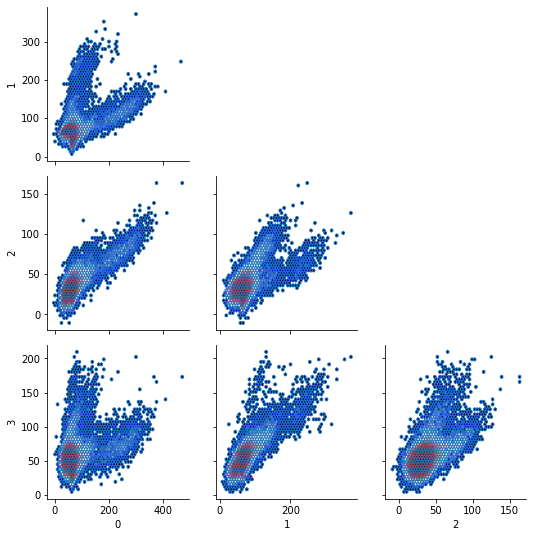

In [7]:
# Code from class which is taking forever and not running
g = sns.PairGrid(PP)
g = g.map_lower(plt.hexbin,gridsize=50, mincnt=1, cmap='seismic',bins='log')
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)

# Clustering with K-means

In [8]:
# Scipy clustering: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html

In [9]:
# 2000 * 40,K=3
# 2 steps: 1-assign rnks and 2-recalculate mks

In [10]:
def cost_function(xn, mk, rnk):
    return rnk*(xn-mk)**2 #returns 0 or the euclidian distance


def iterative_cost_function(xns, mk, rnks): # Cost function for 1 cluster
    n = len(xns)
    J = 0
    for i in range(n):
        if rnks[i]:
            J += cost_function(xns[i], mk, rnks[i])
    return J

def all_clusters_cost_function(xns, mks, rnks): # Cost function for all clusters
    for cluster_i in range(len(mks)):
        J+= iterative_cost_function(xns, mk[i], rnks)
    return J

In [11]:
# Assigning a cluster based on distance between centroids and points:
def distances(xns, mks):
    number_of_clusters = len(mks) #2000
    number_of_datapoints = len(xns) #3
    
    rnks_1 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_2 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_3 = np.zeros(number_of_datapoints, dtype = bool)
    
    for i in range(number_of_datapoints):
        distance = np.zeros(number_of_clusters)
        
        for cluster_i in range(number_of_clusters):
            distance[cluster_i]= np.sum((xns[i]-mks[cluster_i])**2)
            
        minimum = np.argmin(distance)
        
        if minimum ==0: # Belongs in cluster 1
            rnks_1[i] = 1
        elif minimum ==1: # Belongs in cluster 2
            rnks_2[i] = 1
        elif minimum ==2: # Belongs in cluster 3
            rnks_3[i] = 1
    return rnks_1, rnks_2, rnks_3

In [26]:
def plot_traces(xns, rnks_1, rnks_2, rnks_3, mks):
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10,7))
    fig.suptitle('Neuron traces based on cluster', fontsize=20)

    time = [i for i in range(40)]
    for i in range(2000):

        if rnks_1[i]:
            ax1.plot(time, xns[i], marker="o", color="salmon")

        elif rnks_2[i]:
            ax2.plot(time, xns[i], marker="o", color="deeppink")

        elif rnks_3[i]:
            ax3.plot(time, xns[i], marker="o", color="dimgrey")

    ax1.plot(time, mks[0], marker ="o", c="r")
    ax2.plot(time, mks[1], marker ="o", c="purple")
    ax3.plot(time, mks[2], marker ="o", c="k")
    plt.xlabel('Time')
    plt.ylabel("Voltage")
    plt.show()
    return None

In [14]:
# Updating centroids
def updates_centroids(xns, rnks_1, rnks_2, rnks_3):
    c1 = []
    c2 = []
    c3 = []

    for i in range(2000):

        if rnks_1[i]:
            c1.append(xns[i])

        elif rnks_2[i]:
            c2.append(xns[i])

        elif rnks_3[i]:
            c3.append(xns[i])

    mks1 = np.mean(c1, 0)
    mks2 = np.mean(c2, 0)
    mks3 = np.mean(c3, 0)
    
    return mks1, mks2, mks3 

In [12]:
xns = xn_ex2[:2000] # whole 40 time indices of electrode 1
mks_init = [xns[0], xns[40], xns[30]]

rnks_1, rnks_2, rnks_3 = distances(xns, mks_init)
mks1, mks2, mks3 = updates_centroids(xns, rnks_1, rnks_2, rnks_3)
# for i in range(len(mks_init)):
    
#     iterative_cost_function(xns, mk, rnks) # Cost function for 1 cluster
# J = all_clusters_cost_function(Peaks_1[:2000], mks_init, rnks)

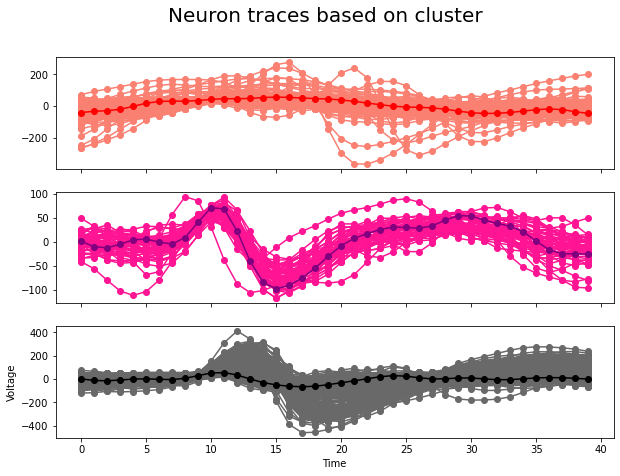

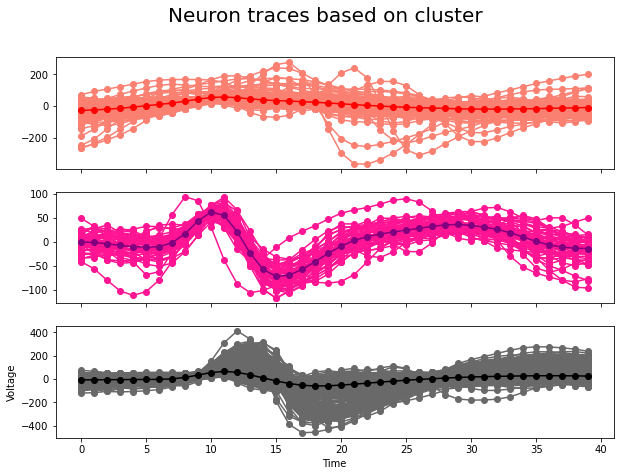

In [28]:
plot_traces(xns, rnks_1, rnks_2, rnks_3, mks_init)
plot_traces(xns, rnks_1, rnks_2, rnks_3, [mks1, mks2, mks3])

# Stop iterating when cost function does not change or when the assignments don't change

https://en.wikipedia.org/wiki/K-means_clustering

https://quick-adviser.com/how-do-you-implement-k-means/